## Importing

In [4]:
# useful additional packages
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import time
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
# from qiskit import Aer, execute
from qiskit.circuit import Parameter
from qiskit.primitives import BackendEstimator,BackendSampler
# General imports
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Pre-defined ansatz circuit, operator class and visualization tools
from qiskit.circuit.library import QAOAAnsatz

from qiskit import transpile
from qiskit_aer import AerSimulator
# from qiskit.visualization import plot_distribution
#from qiskit.quantum_info import SparsePauliOp
# Qiskit Runtime
# from qiskit_ibm_runtime import QiskitRuntimeService
# from qiskit_ibm_runtime import Estimator, Sampler, Session, Options

# SciPy minimizer routine
from scipy.optimize import minimize

# rustworkx graph library
import rustworkx as rx
# from rustworkx.visualization import mpl_draw
import networkx as nx

from qiskit_optimization.applications import Maxcut

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

## Making the Graph

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_1*x_2 - 2*x_2*x_3 - 2*x_3*x_4 - 2*x_3*x_5
  - 2*x_4*x_5 + 2*x_0 + 2*x_1 + 3*x_2 + 3*x_3 + 2*x_4 + 2*x_5

Subject to
  No constraints

  Binary variables (6)
    x_0 x_1 x_2 x_3 x_4 x_5



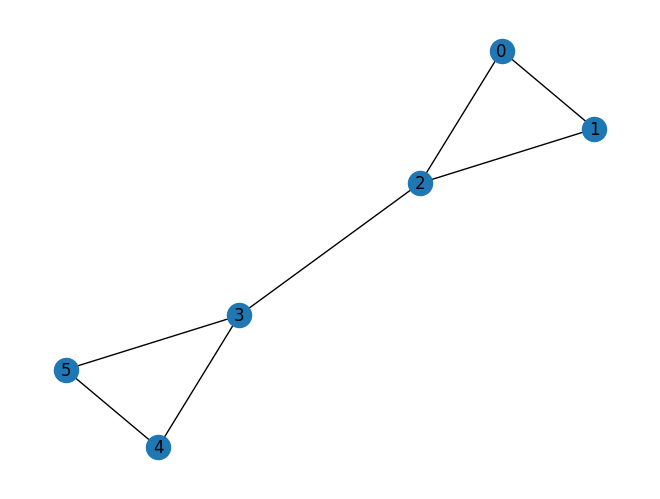

In [2]:
G = nx.Graph()
G.add_edges_from([(0,1),(1,2),(2,0),(3,2),(4,3),(5,3),(4,5)])
nx.draw_spring(G, with_labels=True)
maxcut = Maxcut(G)
problem = maxcut.to_quadratic_program()
print(problem.prettyprint())

In [5]:
num_nodes = 6


# Initialize the weight matrix
w = np.zeros((num_nodes, num_nodes))

# Iterate over the edges of the graph and assign weights to the weight matrix
for edge in G.edges():
    node1, node2 = edge
    w[node1][node2] = 1
    w[node2][node1] = 1  # Assuming undirected graph

# Print the weight matrix
#print("Weight Matrix:")
#print(w)

### Solve it Via Brute Force

case = [0, 0, 0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0, 0, 0] cost = 2.0
case = [0, 1, 0, 0, 0, 0] cost = 2.0
case = [1, 1, 0, 0, 0, 0] cost = 2.0
case = [0, 0, 1, 0, 0, 0] cost = 3.0
case = [1, 0, 1, 0, 0, 0] cost = 3.0
case = [0, 1, 1, 0, 0, 0] cost = 3.0
case = [1, 1, 1, 0, 0, 0] cost = 1.0
case = [0, 0, 0, 1, 0, 0] cost = 3.0
case = [1, 0, 0, 1, 0, 0] cost = 5.0
case = [0, 1, 0, 1, 0, 0] cost = 5.0
case = [1, 1, 0, 1, 0, 0] cost = 5.0
case = [0, 0, 1, 1, 0, 0] cost = 4.0
case = [1, 0, 1, 1, 0, 0] cost = 4.0
case = [0, 1, 1, 1, 0, 0] cost = 4.0
case = [1, 1, 1, 1, 0, 0] cost = 2.0
case = [0, 0, 0, 0, 1, 0] cost = 2.0
case = [1, 0, 0, 0, 1, 0] cost = 4.0
case = [0, 1, 0, 0, 1, 0] cost = 4.0
case = [1, 1, 0, 0, 1, 0] cost = 4.0
case = [0, 0, 1, 0, 1, 0] cost = 5.0
case = [1, 0, 1, 0, 1, 0] cost = 5.0
case = [0, 1, 1, 0, 1, 0] cost = 5.0
case = [1, 1, 1, 0, 1, 0] cost = 3.0
case = [0, 0, 0, 1, 1, 0] cost = 3.0
case = [1, 0, 0, 1, 1, 0] cost = 5.0
case = [0, 1, 0, 1, 1, 0] cost = 5.0
c

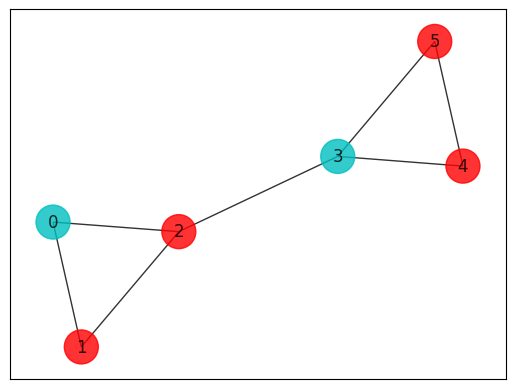

In [6]:
pos = nx.spring_layout(G)
tic = time.time()
best_cost_brute = 0
for b in range(2**num_nodes):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(num_nodes)))]
    cost = 0
    for i in range(num_nodes):
        for j in range(num_nodes):
            cost = cost + w[i, j] * x[i] * (1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print("case = " + str(x) + " cost = " + str(cost))

colors = ["r" if xbest_brute[i] == 0 else "c" for i in range(num_nodes)]
draw_graph(G, colors, pos)
print("\nBest solution = " + str(xbest_brute) + " cost = " + str(best_cost_brute))
toc = time.time()
print("elapsed time = " + str(toc - tic) + " sec")

## Max CUT

### Classical

In [7]:
max_cut = Maxcut(G)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_1*x_2 - 2*x_2*x_3 - 2*x_3*x_4 - 2*x_3*x_5
  - 2*x_4*x_5 + 2*x_0 + 2*x_1 + 3*x_2 + 3*x_3 + 2*x_4 + 2*x_5

Subject to
  No constraints

  Binary variables (6)
    x_0 x_1 x_2 x_3 x_4 x_5



In [8]:
qubitOp, offset = qp.to_ising()
# Problem to Hamiltonian operator
hamiltonian = qubitOp
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: -3.5
Ising Hamiltonian:
SparsePauliOp(['IIIIZZ', 'IIIZIZ', 'IIIZZI', 'IIZZII', 'IZZIII', 'ZIZIII', 'ZZIIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])


### QAOA

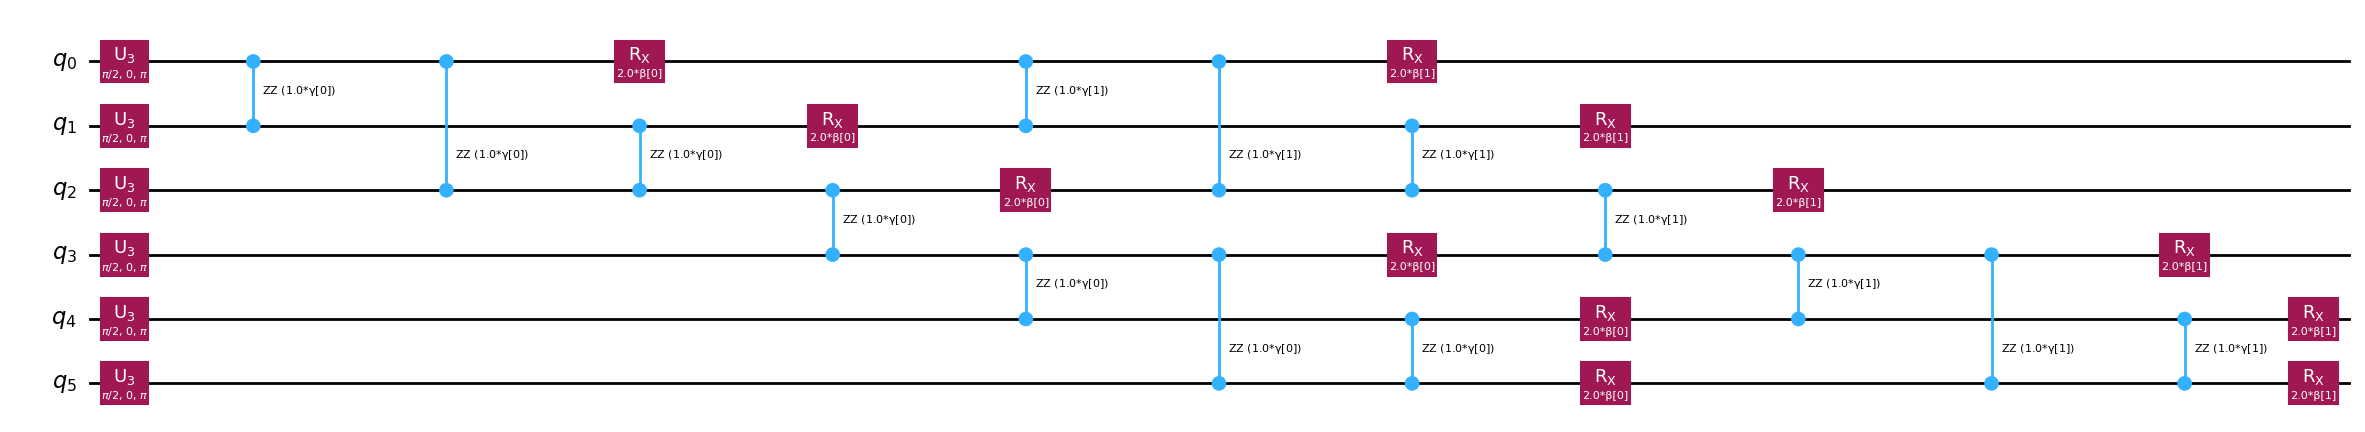

In [11]:
# QAOA ansatz circuit
ansatz = QAOAAnsatz(hamiltonian, reps=2)

# the reps in decompose means, the number of times the circuit should be decomposed
# for example reps = 2 means circuit.decompise().decompose()
ansatz.decompose(reps=3).draw(output="mpl", style="iqp",fold=-1)



In [12]:
print(f"Number of Qubits: {ansatz.num_qubits}")
print(f"Number of Parameters: {ansatz.num_parameters}")

Number of Qubits: 6
Number of Parameters: 4


In [13]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

In [16]:
backend = AerSimulator(method='statevector')
estimator = BackendEstimator(backend=backend)
sampler = BackendSampler(backend=backend)
x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)
print(x0)

[1.18616175 0.88879219 5.15162058 5.81938544]


In [17]:
tic = time.time()
res = minimize(cost_func, x0, args=(ansatz, hamiltonian, estimator), method="POWELL", options={"maxiter": 100})
toc = time.time()
print("elapsed time = " + str(toc - tic) + " sec")


elapsed time = 17.406529426574707 sec


In [18]:
res

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -1.169921875
       x: [ 2.251e+00  1.206e+00  5.696e+00  6.361e+00]
     nit: 8
   direc: [[ 1.000e+00  0.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
    nfev: 565

In [19]:
print(f"Solved Parameters: {res.x}")

Solved Parameters: [2.25053155 1.20594467 5.69637496 6.36115771]


### Getting Result

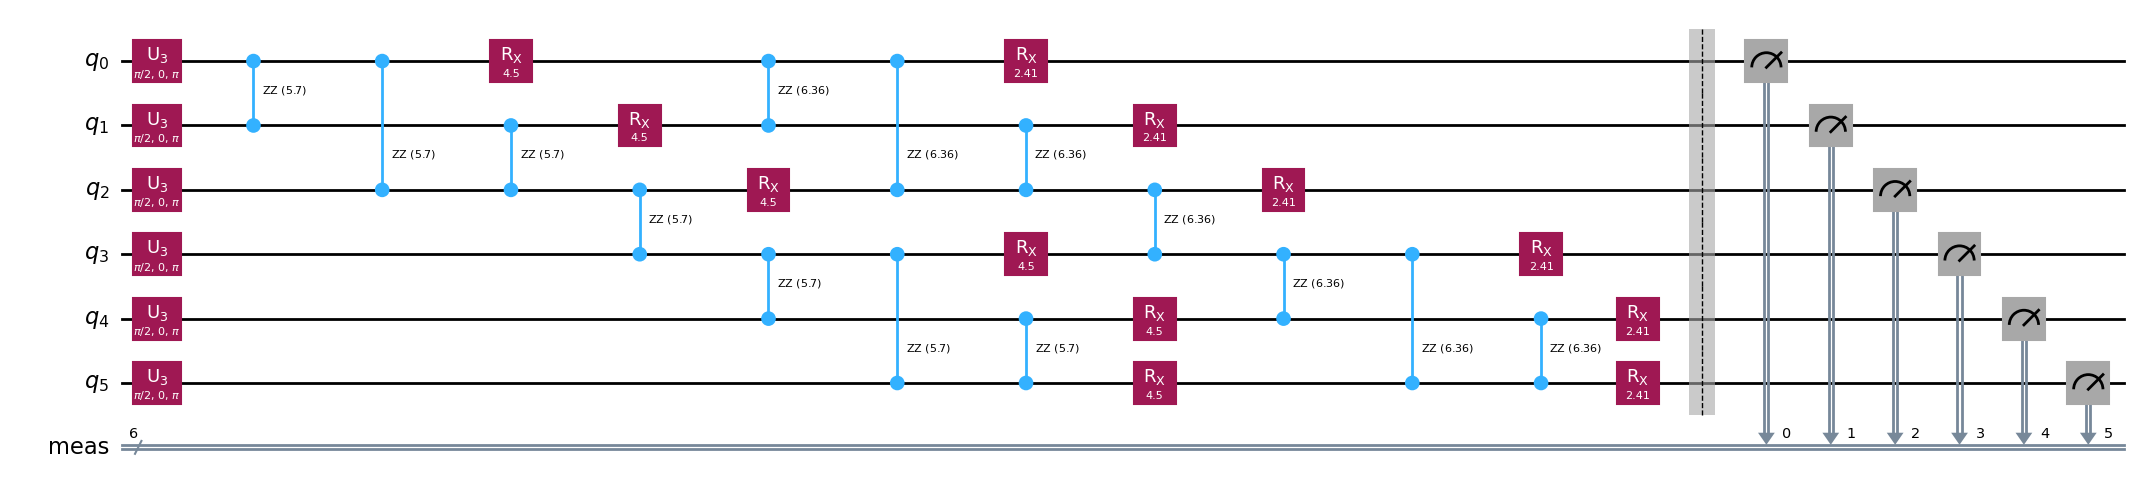

In [21]:
# Assign solution parameters to ansatz
qc = ansatz.assign_parameters(res.x)
# Add measurements to our circuit
qc.measure_all()
qc.decompose(reps=3).draw(output="mpl",style = 'iqx',fold=-1)

In [22]:
# Sample ansatz at optimal parameters
samp_dist = sampler.run(qc).result().quasi_dists[0]
my_dict = dict(sorted(samp_dist.binary_probabilities().items(),key=lambda item: item[1], reverse=True))
#my_dict = samp_dist.binary_probabilities()
print(my_dict) 

{'100101': 0.052734375, '010110': 0.048828125, '100110': 0.0478515625, '010101': 0.0478515625, '101001': 0.0458984375, '011010': 0.0458984375, '010100': 0.0439453125, '110101': 0.041015625, '101010': 0.0400390625, '110110': 0.0380859375, '011011': 0.0341796875, '011001': 0.033203125, '001011': 0.0322265625, '100100': 0.0322265625, '001100': 0.03125, '110011': 0.0302734375, '101011': 0.029296875, '001010': 0.02734375, '001001': 0.02734375, '110100': 0.0244140625, '110010': 0.0244140625, '010011': 0.0224609375, '101100': 0.021484375, '110001': 0.0185546875, '100011': 0.017578125, '001110': 0.0166015625, '001101': 0.015625, '011100': 0.013671875, '100001': 0.0126953125, '010001': 0.0126953125, '101110': 0.01171875, '100010': 0.009765625, '011110': 0.0087890625, '010010': 0.0078125, '011101': 0.0078125, '111100': 0.00390625, '101101': 0.00390625, '110000': 0.0029296875, '010000': 0.0029296875, '000001': 0.001953125, '111110': 0.001953125, '000010': 0.001953125, '111111': 0.0009765625, '111

In [23]:
print("Brute Force Solution: ", xbest_brute)
# first result from my_dict
print("QAOA Solution: ", list(my_dict.keys())[0])

Brute Force Solution:  [1, 0, 0, 1, 0, 0]
QAOA Solution:  100101


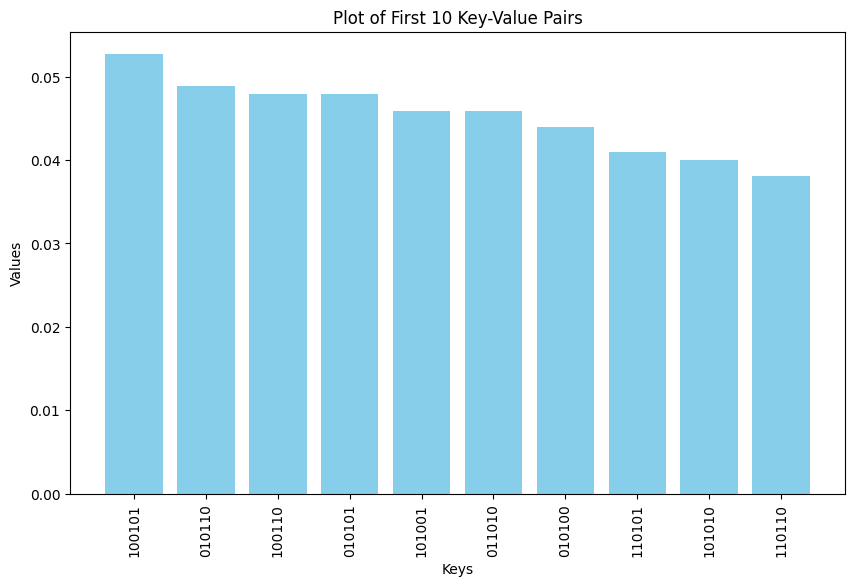

In [24]:
# plot the histogram of my_dict, for only first 10 elements
# Extract first 10 key-value pairs
first_10_items = list(my_dict.items())[:10]
x_values = [item[0] for item in first_10_items]
y_values = [item[1] for item in first_10_items]

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(x_values, y_values, color='skyblue')
plt.xlabel('Keys')
plt.ylabel('Values')
plt.title('Plot of First 10 Key-Value Pairs')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

### Transpiling and Re Confirming

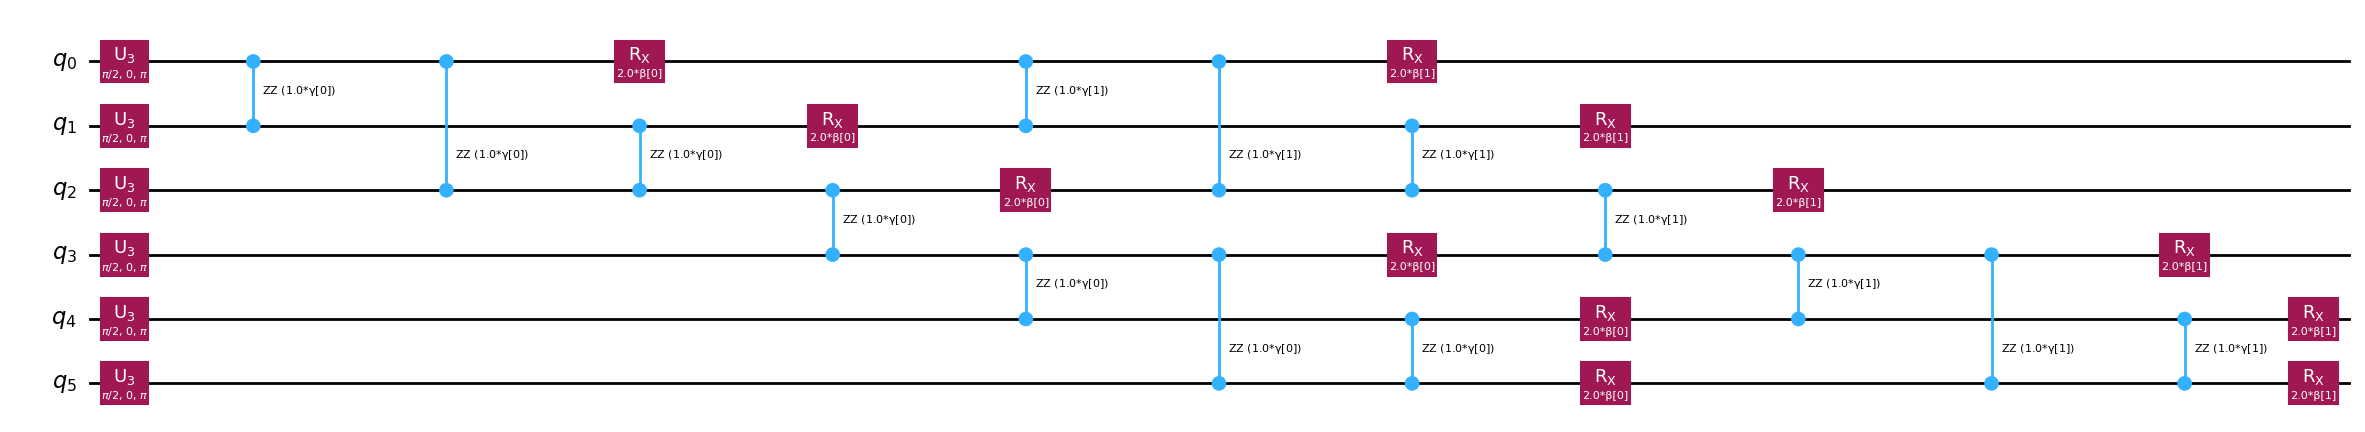

In [25]:
# QAOA ansatz circuit
ansatz = QAOAAnsatz(hamiltonian, reps=2)

ansatz.decompose(reps=3).draw(output="mpl", style="iqp",fold=-1)

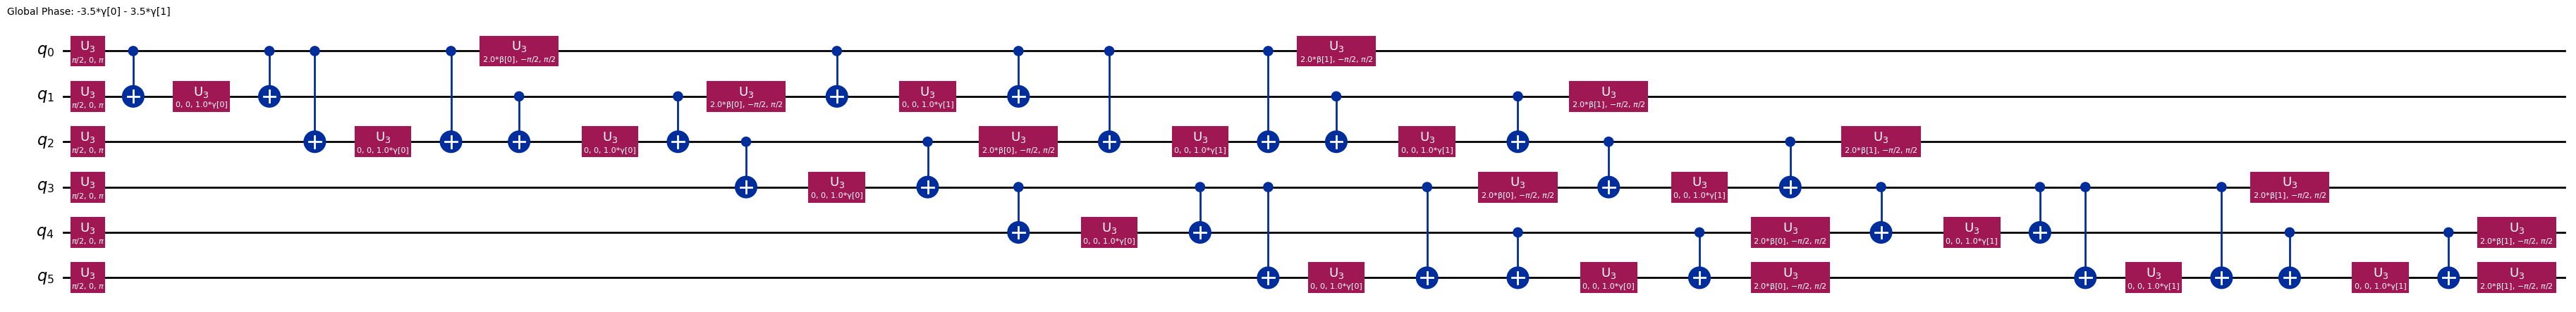

In [26]:
circuit_basis = transpile(ansatz, basis_gates=['u3', 'cx'], optimization_level=3)
circuit_basis.draw(output="mpl", style="iqp",fold=-1)

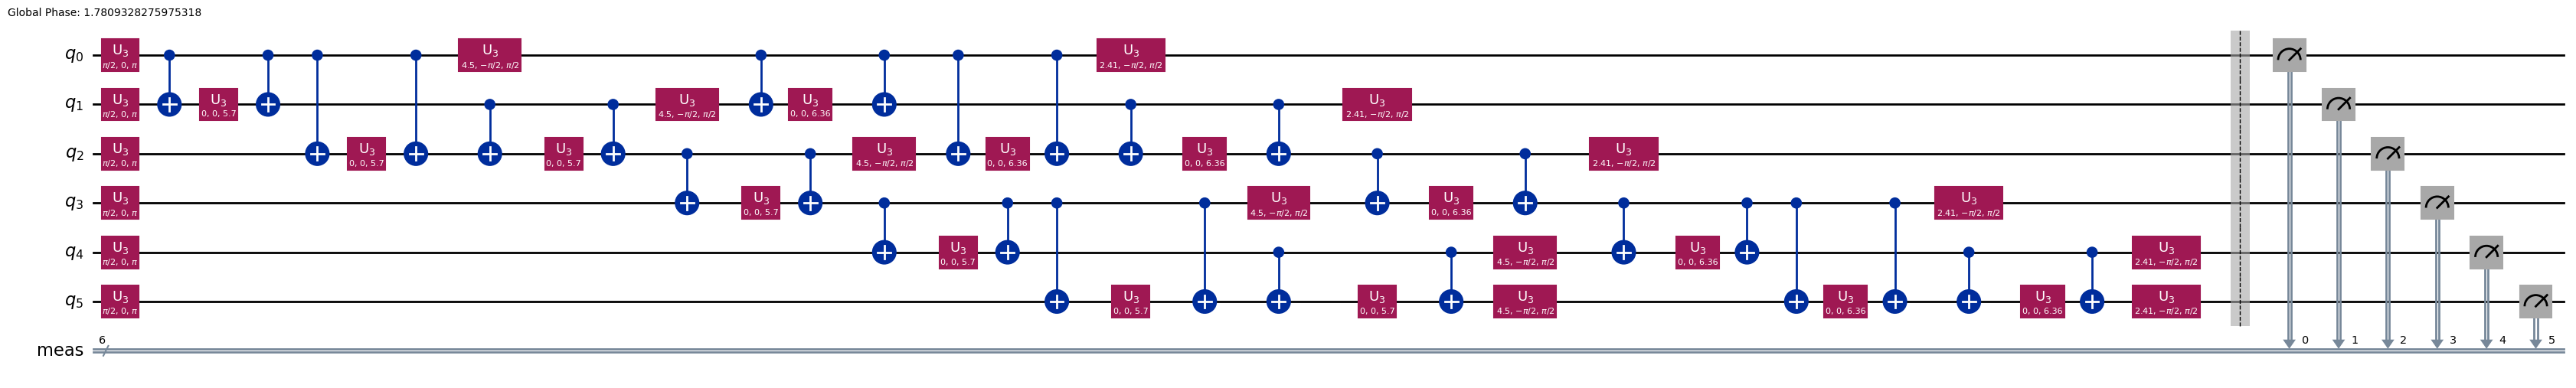

In [27]:
circuit_recheck = circuit_basis.assign_parameters(res.x)
circuit_recheck.measure_all()
circuit_recheck.draw(output="mpl", style="iqp",fold=-1)

In [28]:
# Sample ansatz at optimal parameters
samp_dist1 = sampler.run(circuit_recheck).result().quasi_dists[0]
my_dict1 = dict(sorted(samp_dist1.binary_probabilities().items(),key=lambda item: item[1], reverse=True))
#my_dict1 = samp_dist1.binary_probabilities()
print(my_dict1) 

{'010101': 0.056640625, '010110': 0.0517578125, '011010': 0.048828125, '011001': 0.046875, '100101': 0.0439453125, '100110': 0.0439453125, '110101': 0.04296875, '011011': 0.04296875, '101011': 0.0419921875, '101010': 0.0419921875, '101001': 0.0400390625, '001001': 0.0361328125, '110110': 0.0361328125, '010100': 0.0361328125, '110011': 0.029296875, '001010': 0.0283203125, '100100': 0.02734375, '001011': 0.025390625, '001100': 0.025390625, '110100': 0.0244140625, '101100': 0.01953125, '100011': 0.01953125, '001101': 0.0185546875, '001110': 0.017578125, '100010': 0.0166015625, '010011': 0.0146484375, '101101': 0.0126953125, '101110': 0.0126953125, '110010': 0.0126953125, '011100': 0.0126953125, '011110': 0.01171875, '010001': 0.009765625, '110001': 0.0087890625, '100001': 0.0078125, '011101': 0.0068359375, '010010': 0.0068359375, '010000': 0.0029296875, '100000': 0.0029296875, '110000': 0.0029296875, '000010': 0.001953125, '000001': 0.001953125, '000101': 0.001953125, '000011': 0.00097656

#### Comparing

In [30]:
print(f"Previous Solution: {(my_dict)}")
print(f"New Solution: {(my_dict1)}")

Previous Solution: {'100101': 0.052734375, '010110': 0.048828125, '100110': 0.0478515625, '010101': 0.0478515625, '101001': 0.0458984375, '011010': 0.0458984375, '010100': 0.0439453125, '110101': 0.041015625, '101010': 0.0400390625, '110110': 0.0380859375, '011011': 0.0341796875, '011001': 0.033203125, '001011': 0.0322265625, '100100': 0.0322265625, '001100': 0.03125, '110011': 0.0302734375, '101011': 0.029296875, '001010': 0.02734375, '001001': 0.02734375, '110100': 0.0244140625, '110010': 0.0244140625, '010011': 0.0224609375, '101100': 0.021484375, '110001': 0.0185546875, '100011': 0.017578125, '001110': 0.0166015625, '001101': 0.015625, '011100': 0.013671875, '100001': 0.0126953125, '010001': 0.0126953125, '101110': 0.01171875, '100010': 0.009765625, '011110': 0.0087890625, '010010': 0.0078125, '011101': 0.0078125, '111100': 0.00390625, '101101': 0.00390625, '110000': 0.0029296875, '010000': 0.0029296875, '000001': 0.001953125, '111110': 0.001953125, '000010': 0.001953125, '111111':

## Wire Cut

In [39]:
circuit_basis = circuit_basis.assign_parameters(res.x)

In [40]:
%%capture

from circuit_knitting.cutting.cutqc import cut_circuit_wires

cuts = cut_circuit_wires(
    circuit=circuit_basis,
    method="automatic",
    max_subcircuit_width=4,
    max_cuts=4,
    num_subcircuits=[2],
)



In [49]:

print("Total number of cuts: ",cuts['num_cuts'])
print("Number of subcircuits: ",len(cuts['subcircuits']))

# or can do
print("Number of subcircuits: ",len(subcircuit_instance_probabilities))

Total number of cuts:  2
Number of subcircuits:  2
Number of subcircuits:  2


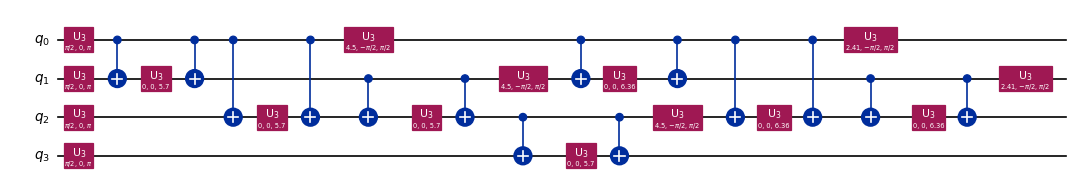

In [50]:
# visualize the first subcircuit
cuts["subcircuits"][0].draw("mpl",style='iqx', fold=-1, scale=0.6)

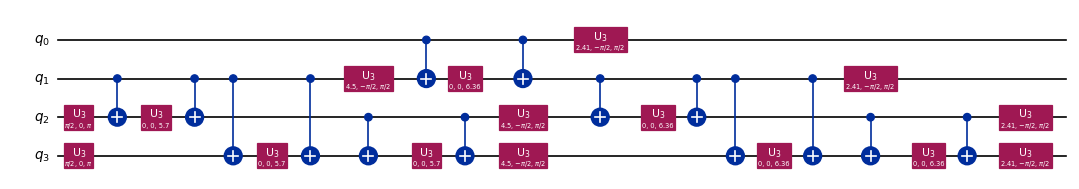

In [51]:
# visualize the second subcircuit
cuts["subcircuits"][1].draw("mpl",style='iqx', fold=-1, scale=0.6)

### Evaluate

In [52]:
from circuit_knitting.cutting.cutqc import evaluate_subcircuits

subcircuit_instance_probabilities = evaluate_subcircuits(cuts)

In [53]:
print(
    "Number of variants of 1st subcircuit: ", len(subcircuit_instance_probabilities[0])
)
print(
    "Number of variants of 2nd subcircuit: ", len(subcircuit_instance_probabilities[1])
)


Number of variants of 1st subcircuit:  16
Number of variants of 2nd subcircuit:  16


In [54]:
%%capture

from circuit_knitting.cutting.cutqc import (
    reconstruct_full_distribution,
)

reconstructed_probabilities = reconstruct_full_distribution(
    circuit_basis, subcircuit_instance_probabilities, cuts
)

In [55]:
print(
    "Size of reconstructed probability distribution: ", len(reconstructed_probabilities)
)

Size of reconstructed probability distribution:  64


In [56]:
from circuit_knitting.cutting.cutqc import verify

metrics, exact_probabilities = verify(circuit_basis, reconstructed_probabilities)

In [57]:
metrics

{'nearest': {'chi2': 0,
  'Mean Squared Error': 2.9718188396846363e-34,
  'Mean Absolute Percentage Error': 9.521939065126895e-13,
  'Cross Entropy': 3.5552326972032122,
  'HOP': 0.9157557373014973},
 'naive': {'chi2': 0,
  'Mean Squared Error': 2.5044821194441533e-34,
  'Mean Absolute Percentage Error': 9.59345200464924e-13,
  'Cross Entropy': 3.5552326972032113,
  'HOP': 0.9157557373014976}}

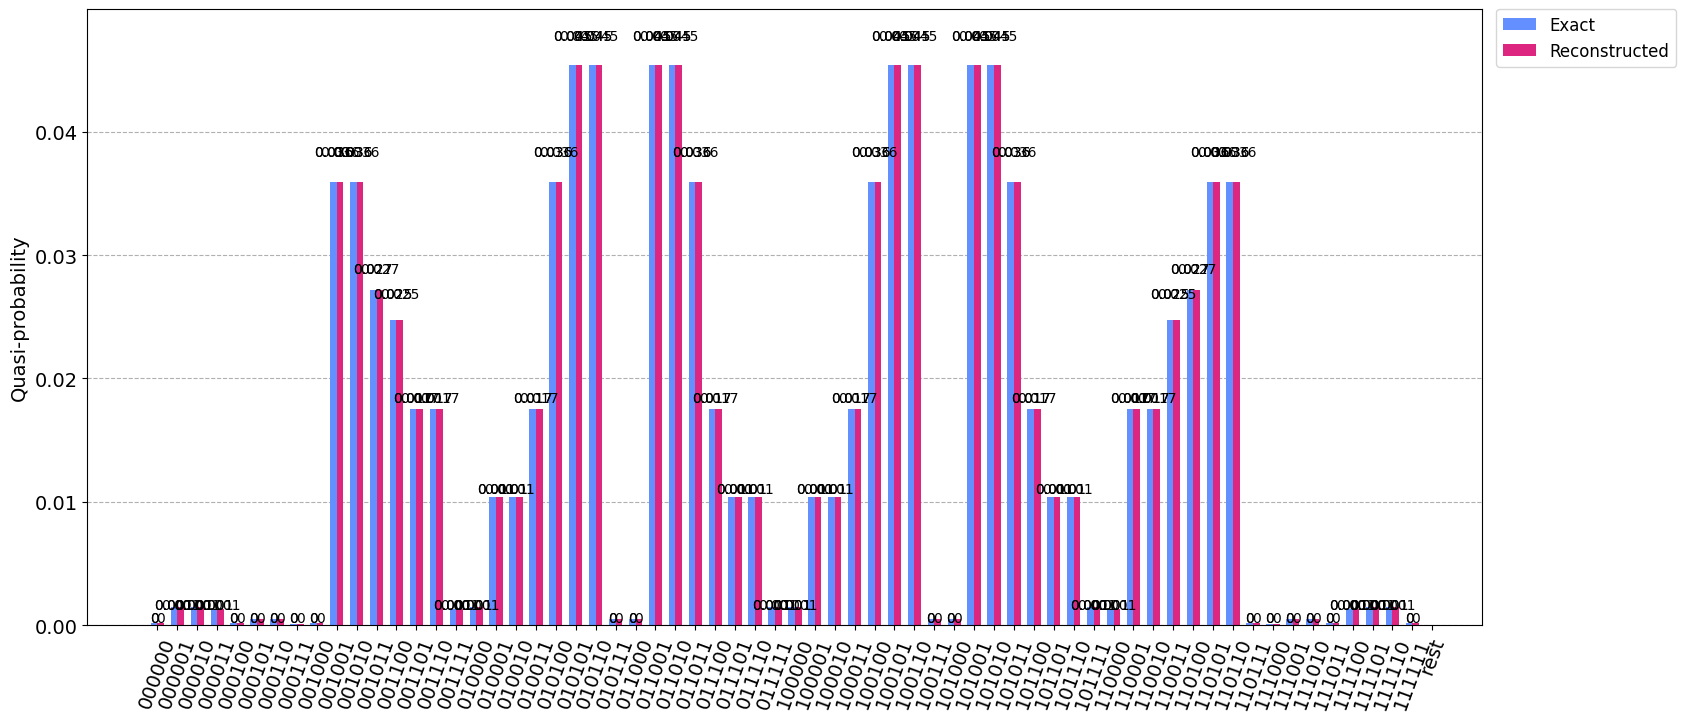

In [61]:
num_qubits = circuit_basis.num_qubits
from qiskit.visualization import plot_histogram
from qiskit.result import ProbDistribution

# Create a dict for the reconstructed distribution
reconstructed_distribution = {
    i: prob for i, prob in enumerate(reconstructed_probabilities)
}

# Represent states as bitstrings (instead of ints)
reconstructed_dict_bitstring = ProbDistribution(
    data=reconstructed_distribution
).binary_probabilities(num_bits=num_qubits)


# Create the ground truth distribution dict
exact_distribution = {i: prob for i, prob in enumerate(exact_probabilities)}

# Represent states as bitstrings (instead of ints)
exact_dict_bitstring = ProbDistribution(data=exact_distribution).binary_probabilities(
    num_bits=num_qubits
)
sorted_exact_dict_bitstring = sorted(exact_dict_bitstring.items(), key=lambda x: x[1], reverse=True)
sorted_exact_dict_bitstring = dict(sorted_exact_dict_bitstring)
sorted_reconstructed_dict_bitstring   = sorted(reconstructed_dict_bitstring.items(), key=lambda x: x[1], reverse=True)
sorted_reconstructed_dict_bitstring = dict(sorted_reconstructed_dict_bitstring)
# plot a histogram of the distributions
plot_histogram(
    [sorted_exact_dict_bitstring, sorted_reconstructed_dict_bitstring],
    number_to_keep=64,
    figsize=(18, 8),
    sort="asc",
    legend=["Exact", "Reconstructed"],
)

## Gate Cut

In [63]:
from qiskit.quantum_info import PauliList

observables = PauliList(['IIIIZZ', 'IIIZIZ', 'IIIZZI', 'IIZZII', 'IZZIII', 'ZIZIII', 'ZZIIII'])

In [65]:
from circuit_knitting.cutting import partition_problem

partitioned_problem = partition_problem(
    circuit=circuit_basis, partition_labels="AAABBB", observables=observables
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
bases = partitioned_problem.bases

In [66]:
subobservables

{'A': PauliList(['IZZ', 'ZIZ', 'ZZI', 'ZII', 'III', 'III', 'III']),
 'B': PauliList(['III', 'III', 'III', 'IIZ', 'IZZ', 'ZIZ', 'ZZI'])}

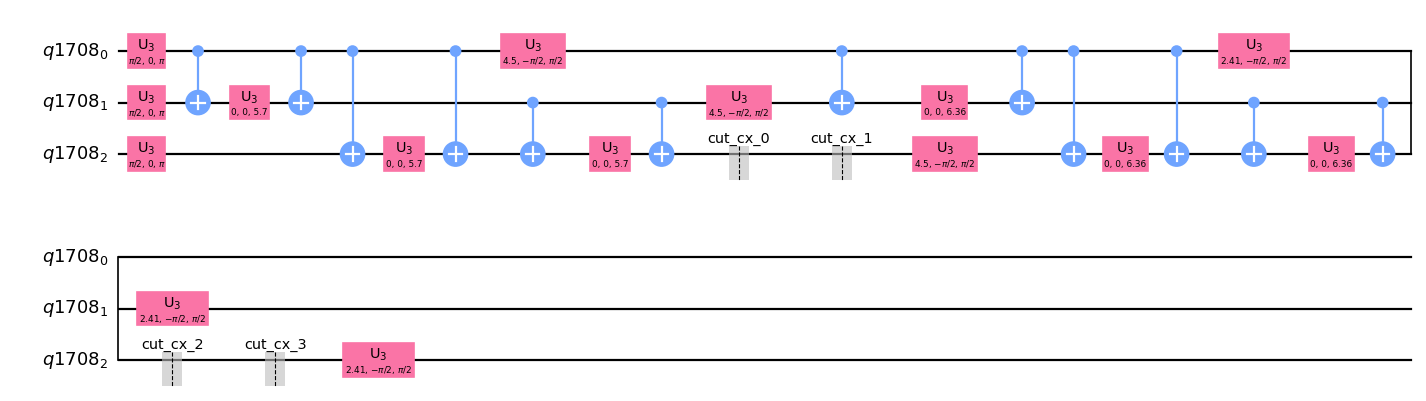

In [67]:
subcircuits["A"].draw("mpl", scale=0.8)

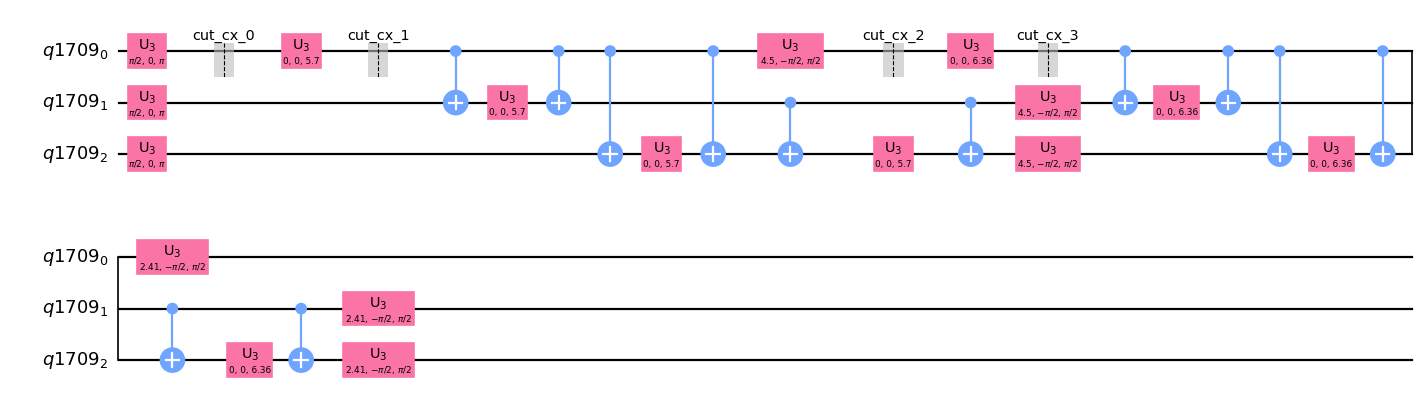

In [68]:
subcircuits["B"].draw("mpl", scale=0.8)

In [69]:
import numpy as np

print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")

Sampling overhead: 6561.0


In [70]:
from circuit_knitting.cutting import generate_cutting_experiments

subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits, observables=subobservables, num_samples=np.inf
)

In [72]:
from qiskit_aer.primitives import Sampler

# Set up a Qiskit Aer Sampler primitive for each circuit partition
samplers = {
    label: Sampler(run_options={"shots": 2**12}) for label in subexperiments.keys()
}

# Retrieve results from each partition's subexperiments
results = {
    label: sampler.run(subexperiments[label]).result()
    for label, sampler in samplers.items()
}

In [73]:
from circuit_knitting.cutting import reconstruct_expectation_values

reconstructed_expvals = reconstruct_expectation_values(
    results,
    coefficients,
    subobservables,
)

In [74]:
from qiskit_aer.primitives import Estimator

estimator = Estimator(run_options={"shots": None}, approximation=True)
exact_expvals = (
    estimator.run([qc] * len(observables), list(observables)).result().values
)
print(
    f"Reconstructed expectation values: {[np.round(reconstructed_expvals[i], 8) for i in range(len(exact_expvals))]}"
)
print(
    f"Exact expectation values: {[np.round(exact_expvals[i], 8) for i in range(len(exact_expvals))]}"
)
print(
    f"Errors in estimation: {[np.round(reconstructed_expvals[i]-exact_expvals[i], 8) for i in range(len(exact_expvals))]}"
)
print(
    f"Relative errors in estimation: {[np.round((reconstructed_expvals[i]-exact_expvals[i]) / exact_expvals[i], 8) for i in range(len(exact_expvals))]}"
)

Reconstructed expectation values: [-0.29905891, -0.28739259, -0.32883787, -0.39831059, -0.2869875, -0.33350125, -0.35866518]
Exact expectation values: [-0.33675287, -0.30946239, -0.30946239, -0.42032505, -0.30946239, -0.30946239, -0.33675287]
Errors in estimation: [0.03769396, 0.0220698, -0.01937549, 0.02201447, 0.02247489, -0.02403886, -0.02191231]
Relative errors in estimation: [-0.11193359, -0.07131658, 0.06261015, -0.05237486, -0.07262559, 0.07767944, 0.06506941]


## Best Cut

Found solution using 2 cuts with a sampling overhead of 256.0.
Wire Cut at index 31
Wire Cut at index 40


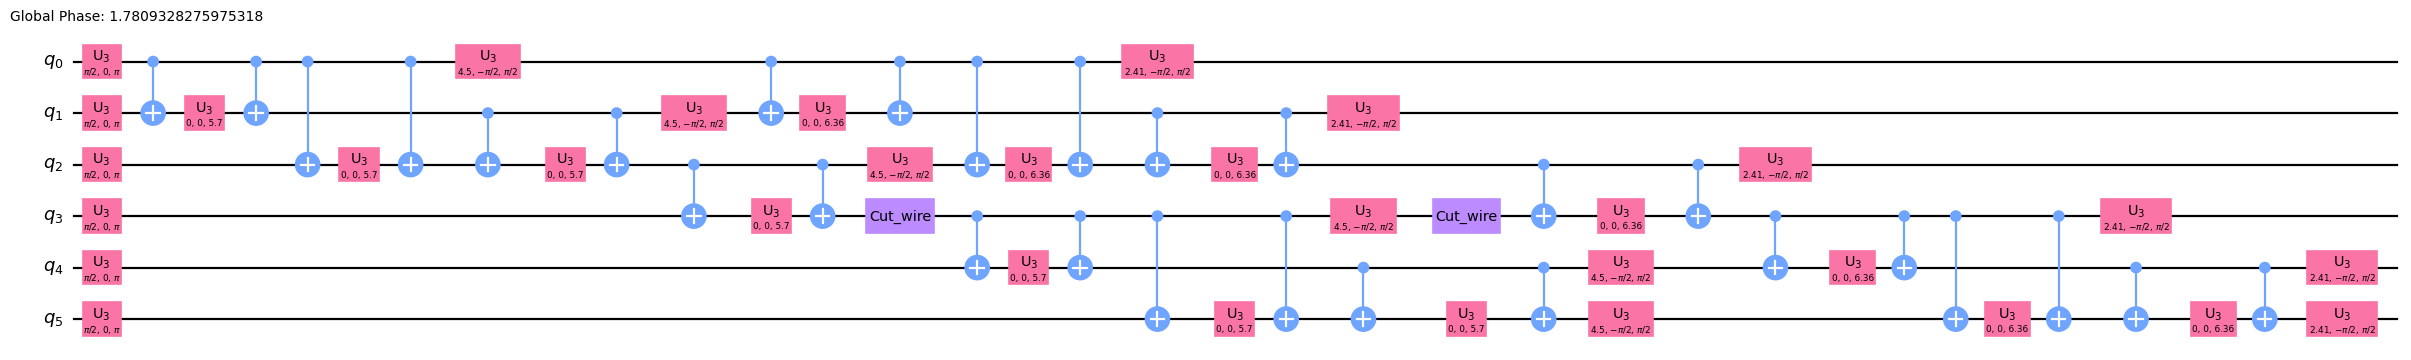

In [75]:
from circuit_knitting.cutting import find_cuts

# Specify settings
optimization_settings = {"rand_seed":111}

# specify device constraints
device_constraints = {"qubits_per_QPU": 5, "num_QPUs": 5}


cut_circuit, metadata = find_cuts(circuit_basis, optimization_settings, device_constraints)
print(
    f'Found solution using {len(metadata["cuts"])} cuts with a sampling '
    f'overhead of {metadata["sampling_overhead"]}.'
)
for cut in metadata["cuts"]:
    print(f"{cut[0]} at index {cut[1]}")
cut_circuit.draw("mpl", scale=0.8, fold=-1)